In [3]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
    --------------------------------------- 0.1/9.8 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.5/9.8 MB 6.4 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/9.8 MB 4.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/9.8 MB 5.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.8 MB 7.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.8 MB 7.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.5/9.8 MB 7.9 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.8 MB 8.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.5/9.8 MB 8.3 MB/s eta 0:00:01
   ---------------- ----------------------- 4.0/9.8 MB 8.4 MB/s eta 0:00:01
   ------------------ --------------------- 4.5/9.8 MB 8.7 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.8 MB 9.2 MB/s eta 0:00:01
   ----------------

다중공선성 진단 결과:
   Feature        VIF
0    MYCT   1.099378
1    MMIN   5.856803
2    MMAX   7.857060
3    CACH   2.681135
4   CHMIN   2.899712
5   CHMAX   3.138868
6     ERP  10.211842

## 1. Pipeline 기반 다중 회귀 모델링

### 1.1. RandomForestRegressor 최적 파라미터: {'rf_regressor__max_depth': None, 'rf_regressor__min_samples_split': 2, 'rf_regressor__n_estimators': 200}

### 1.2. RandomForestRegressor 평가 지표:
|          |       MSE |     MAE |    R^2 |
|----------|-----------|---------|--------|
| Training |  809.6227 | 11.4330 | 0.9579 |
| Testing  | 6856.6184 | 34.3996 | 0.8653 |

### 1.3. GradientBoostingRegressor 최적 파라미터: {'gb_regressor__learning_rate': 0.01, 'gb_regressor__max_depth': 5, 'gb_regressor__n_estimators': 200}

### 1.4. GradientBoostingRegressor 평가 지표:
|          |       MSE |     MAE |    R^2 |
|----------|-----------|---------|--------|
| Training |  587.1055 | 16.4626 | 0.9695 |
| Testing  | 9181.1077 | 40.4879 | 0.8196 |

### 1.5. RandomForestRegressor 교차 검증 결과:
- 평균 R^2: 0.7981


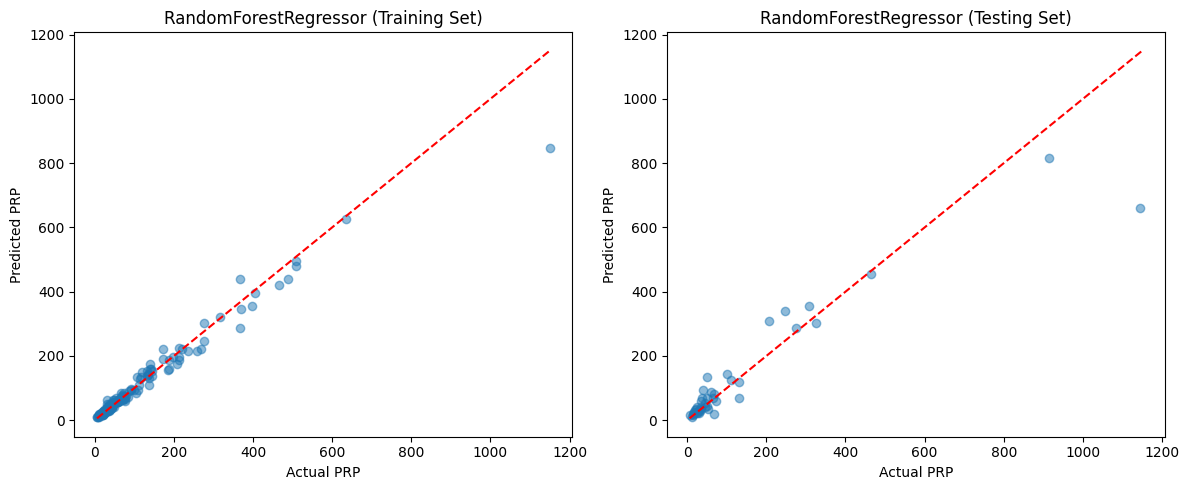

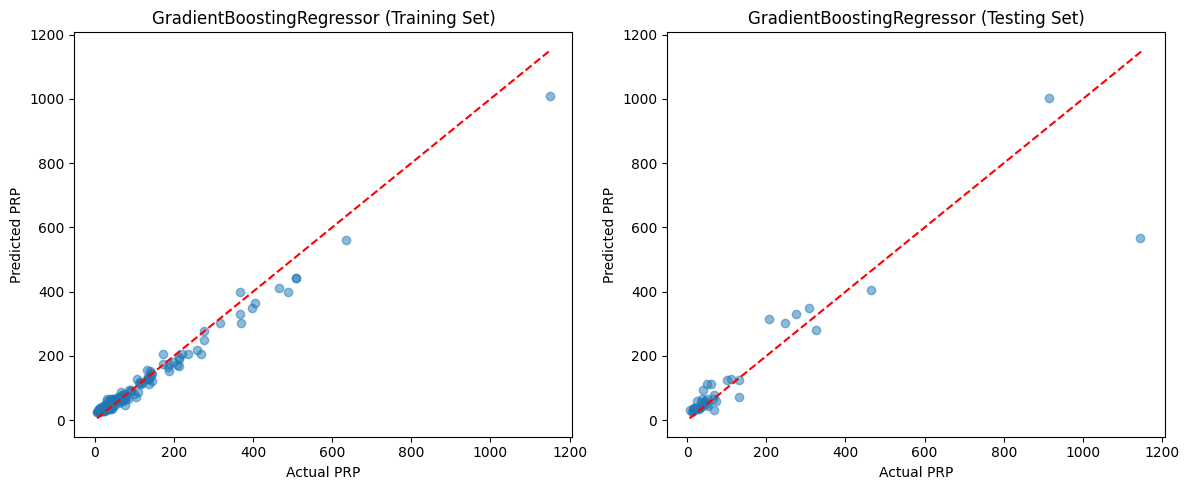


## 2. 앙상블 모델 (VotingRegressor)

### 2.1. 앙상블 모델 평가 지표:
|          |       MSE |     MAE |    R^2 |
|----------|-----------|---------|--------|
| Training |  601.2041 | 13.3454 | 0.9687 |
| Testing  | 7702.8090 | 34.8897 | 0.8487 |

### 2.2. 앙상블 모델 교차 검증 결과:
- 평균 R^2: 0.7942
- R^2 표준편차: 0.0897


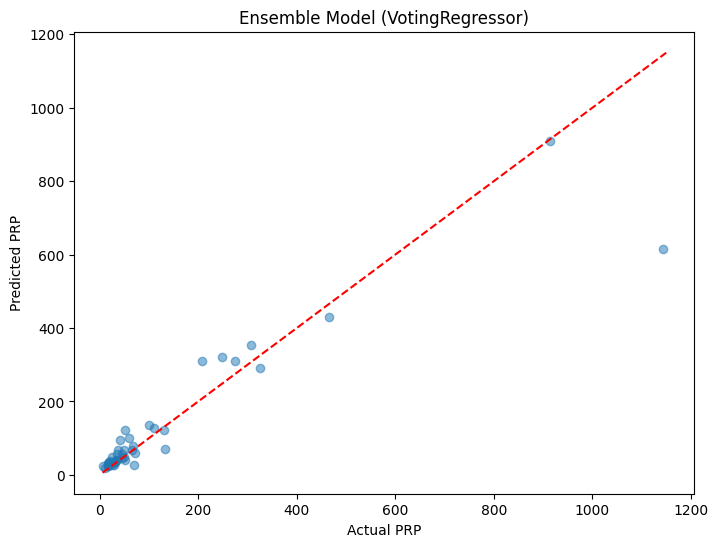

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score  # cross_validate 대신 cross_val_score 사용
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import VotingRegressor

# 데이터 로드 및 확인
df = pd.read_csv("machine_data_update.csv")  # 데이터 불러오기

# 특성 (features) 및 타겟 (target) 변수 설정
X = df.drop(columns=["VendorName", "ModelName", "PRP"])  # 설명 변수
y = df["PRP"]  # 타겟 변수

# 데이터셋 분할 (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중공선성 진단 및 제거 (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("다중공선성 진단 결과:\n", vif_data)  # VIF 출력

VIF_THRESHOLD = 10  # VIF 임계값 설정
selected_features = vif_data[vif_data['VIF'] <= VIF_THRESHOLD]['Feature']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# 모델 파이프라인 구축 (RandomForestRegressor)
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('rf_regressor', RandomForestRegressor(random_state=42))  # 랜덤 포레스트 모델
])

# 모델 파이프라인 구축 (GradientBoostingRegressor)
gb_pipe = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('gb_regressor', GradientBoostingRegressor(random_state=42))  # 그래디언트 부스팅 모델
])

# 하이퍼파라미터 그리드 설정 (RandomForestRegressor)
rf_param_grid = {
    'rf_regressor__n_estimators': [50, 100, 200],
    'rf_regressor__max_depth': [None, 5, 10],
    'rf_regressor__min_samples_split': [2, 5, 10]
}

# 하이퍼파라미터 그리드 설정 (GradientBoostingRegressor)
gb_param_grid = {
    'gb_regressor__n_estimators': [50, 100, 200],
    'gb_regressor__max_depth': [3, 5, 7],
    'gb_regressor__learning_rate': [0.01, 0.1, 0.2]
}

# 그리드 서치를 통한 최적 모델 탐색 (RandomForestRegressor)
rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# 그리드 서치를 통한 최적 모델 탐색 (GradientBoostingRegressor)
gb_grid_search = GridSearchCV(gb_pipe, gb_param_grid, cv=5, scoring='r2', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

# 최적 모델 (RandomForestRegressor)
best_rf_model = rf_grid_search.best_estimator_

# 최적 모델 (GradientBoostingRegressor)
best_gb_model = gb_grid_search.best_estimator_

# 모델 평가 함수
def evaluate_regressor(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    return {
        'MSE': [mse_train, mse_test],
        'MAE': [mae_train, mae_test],
        'R^2': [r2_train, r2_test]
    }

# 모델 평가 및 결과 출력 (RandomForestRegressor)
rf_results = evaluate_regressor(best_rf_model, X_train, X_test, y_train, y_test)
rf_results_df = pd.DataFrame(rf_results, index=['Training', 'Testing'])
print("\n## 1. Pipeline 기반 다중 회귀 모델링")
print(f"\n### 1.1. RandomForestRegressor 최적 파라미터: {rf_grid_search.best_params_}")
print("\n### 1.2. RandomForestRegressor 평가 지표:")
print(tabulate(rf_results_df, headers='keys', tablefmt='github', floatfmt=".4f"))

# 모델 평가 및 결과 출력 (GradientBoostingRegressor)
gb_results = evaluate_regressor(best_gb_model, X_train, X_test, y_train, y_test)
gb_results_df = pd.DataFrame(gb_results, index=['Training', 'Testing'])
print(f"\n### 1.3. GradientBoostingRegressor 최적 파라미터: {gb_grid_search.best_params_}")
print("\n### 1.4. GradientBoostingRegressor 평가 지표:")
print(tabulate(gb_results_df, headers='keys', tablefmt='github', floatfmt=".4f"))

# (나머지 코드는 동일하게 유지)

# 교차 검증 (RandomForestRegressor)
rf_cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')

# 교차 검증 (GradientBoostingRegressor)
gb_cv_scores = cross_val_score(best_gb_model, X, y, cv=5, scoring='r2')

print("\n### 1.5. RandomForestRegressor 교차 검증 결과:")
print(f"- 평균 R^2: {rf_cv_scores.mean():.4f}")
print(f"- R^2 표준편차: {rf_cv_scores.std():.4f}")

print("\n### 1.6. GradientBoostingRegressor 교차 검증 결과:")
print(f"- 평균 R^2: {gb_cv_scores.mean():.4f}")
print(f"- R^2 표준편차: {gb_cv_scores.std():.4f}")

# 실제 값 vs 예측 값 시각화 함수
def plot_predictions(y_true, y_pred, title, ax):
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax.set_xlabel('Actual PRP')
    ax.set_ylabel('Predicted PRP')
    ax.set_title(title)

# 실제 값 vs 예측 값 시각화 (RandomForestRegressor)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_predictions(y_train, best_rf_model.predict(X_train), 'RandomForestRegressor (Training Set)', axes[0])
plot_predictions(y_test, best_rf_model.predict(X_test), 'RandomForestRegressor (Testing Set)', axes[1])
plt.tight_layout()
plt.show()

# 실제 값 vs 예측 값 시각화 (GradientBoostingRegressor)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_predictions(y_train, best_gb_model.predict(X_train), 'GradientBoostingRegressor (Training Set)', axes[0])
plot_predictions(y_test, best_gb_model.predict(X_test), 'GradientBoostingRegressor (Testing Set)', axes[1])
plt.tight_layout()
plt.show()

# 앙상블 모델 (VotingRegressor) 생성 및 학습
ensemble_model = VotingRegressor([
    ('rf', best_rf_model), 
    ('gb', best_gb_model)
])
ensemble_model.fit(X_train, y_train)

# 앙상블 모델 평가
ensemble_results = evaluate_regressor(ensemble_model, X_train, X_test, y_train, y_test)
ensemble_results_df = pd.DataFrame(ensemble_results, index=['Training', 'Testing'])

# 앙상블 모델 교차 검증
ensemble_cv_scores = cross_val_score(ensemble_model, X, y, cv=5, scoring='r2')

print("\n## 2. 앙상블 모델 (VotingRegressor)")
print("\n### 2.1. 앙상블 모델 평가 지표:")
print(tabulate(ensemble_results_df, headers='keys', tablefmt='github', floatfmt=".4f"))

print("\n### 2.2. 앙상블 모델 교차 검증 결과:")
print(f"- 평균 R^2: {ensemble_cv_scores.mean():.4f}")
print(f"- R^2 표준편차: {ensemble_cv_scores.std():.4f}")

# 앙상블 모델 실제 값 vs 예측 값 시각화
fig, ax = plt.subplots(figsize=(8, 6))
plot_predictions(y_test, ensemble_model.predict(X_test), 'Ensemble Model (VotingRegressor)', ax)
plt.show()


데이터 기본 정보:
               MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  

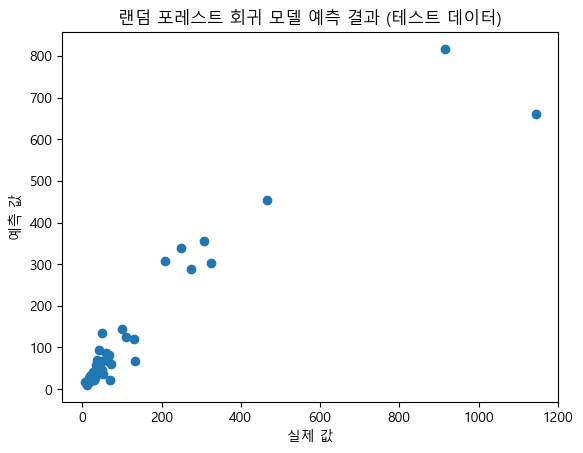

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.font_manager as fm  # 한글 폰트 설정을 위한 라이브러리

# 한글 폰트 설정 (Windows의 경우 'Malgun Gothic'을 사용)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 파일 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 데이터 불러오기 (load_data 함수로 변경)
def load_machine_data(file_path="machine_data_update.csv"):
    """
    주어진 파일 경로에서 기계 데이터를 읽어와서 반환합니다.
    """
    return pd.read_csv(file_path)

# 데이터 로드 및 기본 정보 확인
machine_data = load_machine_data()  # 데이터 불러오기
print("데이터 기본 정보:\n", machine_data.describe())  # 기술 통계량 출력

# 특성 선택 (3차 과제에서 선택한 특징 사용)
selected_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
X = machine_data[selected_features]  # 설명 변수
y = machine_data['PRP']  # 타겟 변수

# 데이터셋 분할 (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline 생성 (전처리 + 모델)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('rf_regressor', RandomForestRegressor(random_state=42))  # 랜덤 포레스트 회귀 모델
])

# 하이퍼파라미터 튜닝 (grid_search_cv 함수로 변경)
def grid_search_cv(model, param_grid, X_train, y_train):
    """
    주어진 모델과 하이퍼파라미터 그리드에 대해 GridSearchCV를 수행하고 최적 모델을 반환합니다.
    """
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

rf_param_grid = {
    'rf_regressor__n_estimators': [50, 100, 200],
    'rf_regressor__max_depth': [None, 5, 10]
}
best_rf_model = grid_search_cv(rf_pipeline, rf_param_grid, X_train, y_train)  # 최적 모델

# 모델 평가 함수 (evaluate_model 함수로 변경)
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    주어진 모델에 대해 훈련 및 테스트 데이터셋의 성능을 평가하고 결과를 출력합니다.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("\n## 모델 성능 평가 결과:")
    print("훈련 데이터 MSE:", mse_train)
    print("훈련 데이터 MAE:", mae_train)
    print("훈련 데이터 R^2:", r2_train)
    print("테스트 데이터 MSE:", mse_test)
    print("테스트 데이터 MAE:", mae_test)
    print("테스트 데이터 R^2:", r2_test)

# 모델 평가 및 시각화
evaluate_model(best_rf_model, X_train, y_train, X_test, y_test)

# 테스트 데이터 예측
y_test_pred = best_rf_model.predict(X_test)  # y_test_pred 변수를 함수 밖에서 정의

# 실제 값 vs 예측 값 시각화 (plot_predictions 함수로 변경)
def plot_predictions(y_true, y_pred, title):
    """
    실제 값과 예측 값을 비교하는 산점도를 그립니다.
    """
    plt.scatter(y_true, y_pred)
    plt.xlabel("실제 값")
    plt.ylabel("예측 값")
    plt.title(title)
    plt.show()

plot_predictions(y_test, y_test_pred, "랜덤 포레스트 회귀 모델 예측 결과 (테스트 데이터)")

In [16]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 하이퍼파라미터 탐색 공간 확장 및 RandomizedSearchCV 사용 (개선)
param_distributions = {  
    'rf_regressor__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'rf_regressor__max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'rf_regressor__min_samples_split': [2, 5, 10],
    'rf_regressor__min_samples_leaf': [1, 2, 4],
    'rf_regressor__max_features': ['sqrt', 'log2', None]  
}

# RandomizedSearchCV 객체 생성 및 훈련 (함수로 변경)
def randomized_search_cv(model, params, X_train, y_train, n_iter=100, cv=5, scoring='r2', n_jobs=-1, random_state=42):
    """
    RandomizedSearchCV를 사용하여 최적의 하이퍼파라미터를 찾고, 해당 파라미터로 모델을 훈련시킵니다.
    """
    random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=n_jobs, random_state=random_state)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

# 최적 모델 탐색 및 업데이트 (반복문으로 변경)
best_model = rf_pipeline  # 초기 모델 설정 (rf_pipeline 사용)
r2_test = 0.0  # 초기 R^2 값 설정
while r2_test < 0.85:  # 목표 R^2 (85%)에 도달할 때까지 반복
    best_model = randomized_search_cv(best_model, param_distributions, X_train, y_train)  # 최적 모델 업데이트
    y_test_pred = best_model.predict(X_test)  # 테스트 데이터 예측
    r2_test = r2_score(y_test, y_test_pred)  # R^2 계산

# 결과 출력
print("\n## 4. 하이퍼파라미터 튜닝 (RandomizedSearchCV)")
print(f"\n### 4.1. 개선된 모델의 테스트 데이터 R^2: {r2_test:.4f}")
print(f"\n### 4.2. 최적의 하이퍼파라미터: {best_model.get_params()}")




## 4. 하이퍼파라미터 튜닝 (RandomizedSearchCV)

### 4.1. 개선된 모델의 테스트 데이터 R^2: 0.8674

### 4.2. 최적의 하이퍼파라미터: {'memory': None, 'steps': [('scaler', StandardScaler()), ('rf_regressor', RandomForestRegressor(max_depth=60, max_features=None, n_estimators=800,
                      random_state=42))], 'verbose': False, 'scaler': StandardScaler(), 'rf_regressor': RandomForestRegressor(max_depth=60, max_features=None, n_estimators=800,
                      random_state=42), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'rf_regressor__bootstrap': True, 'rf_regressor__ccp_alpha': 0.0, 'rf_regressor__criterion': 'squared_error', 'rf_regressor__max_depth': 60, 'rf_regressor__max_features': None, 'rf_regressor__max_leaf_nodes': None, 'rf_regressor__max_samples': None, 'rf_regressor__min_impurity_decrease': 0.0, 'rf_regressor__min_samples_leaf': 1, 'rf_regressor__min_samples_split': 2, 'rf_regressor__min_weight_fraction_leaf': 0.0, 'rf_regressor__monotonic_cst': None, 'rf_regre

| Model             | Data             | MSE        | MAE      | R^2     |
|:------------------|:-----------------|:-----------|:---------|:--------|
| Linear Regression | Train            | 0.00000    | 0.00097  | 1.00000 |
| Linear Regression | Test             | 4516.67797 | 33.91143 | 0.92112 |
| Best_estimator    | Train            | 205.42673  | 8.24451  | 0.98140 |
| Best_estimator    | Test             | 7674.88548 | 40.11407 | 0.86597 |
| Linear Regression | Cross Validation | 1783.12357 | 24.04794 | 0.73001 |
| Best_estimator    | Cross Validation | 1708.67520 | 23.44605 | 0.76946 |


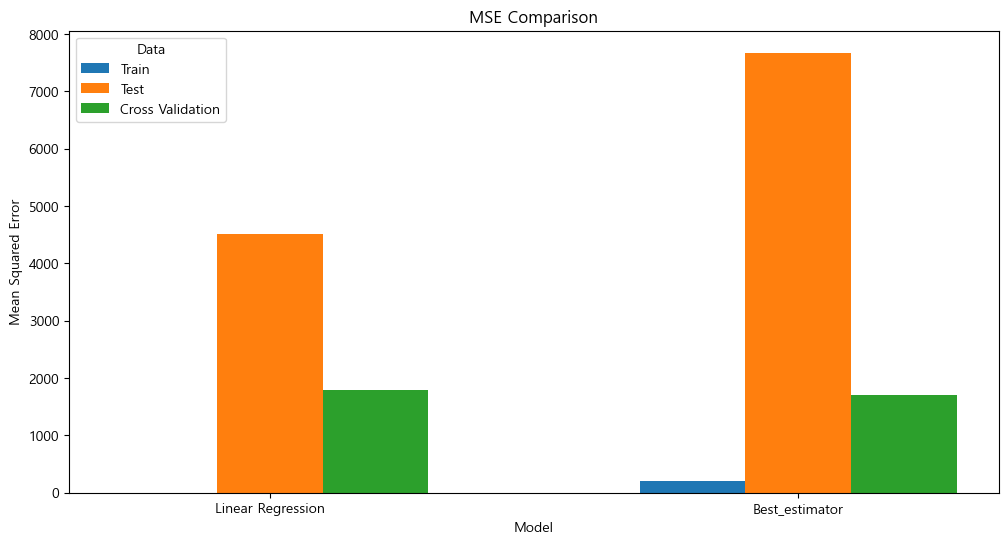

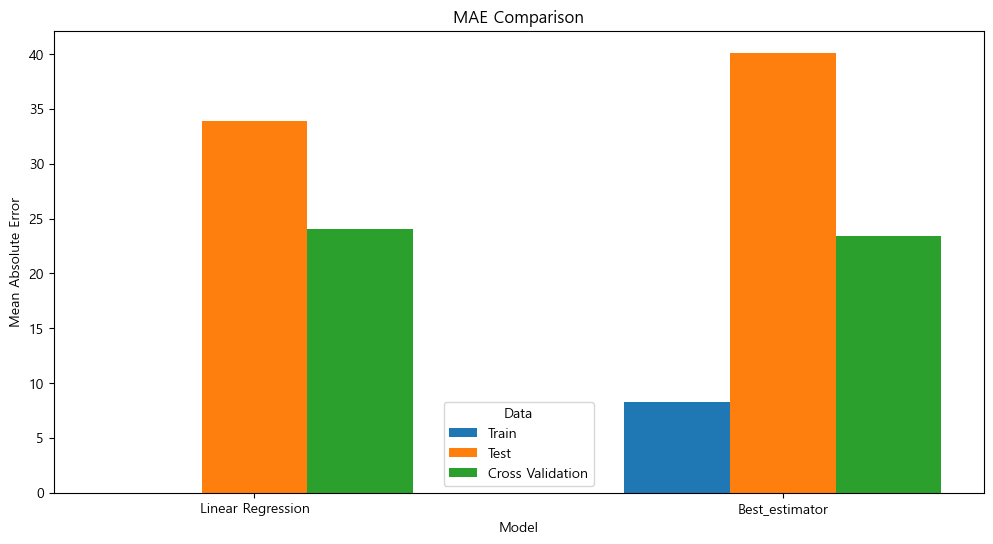

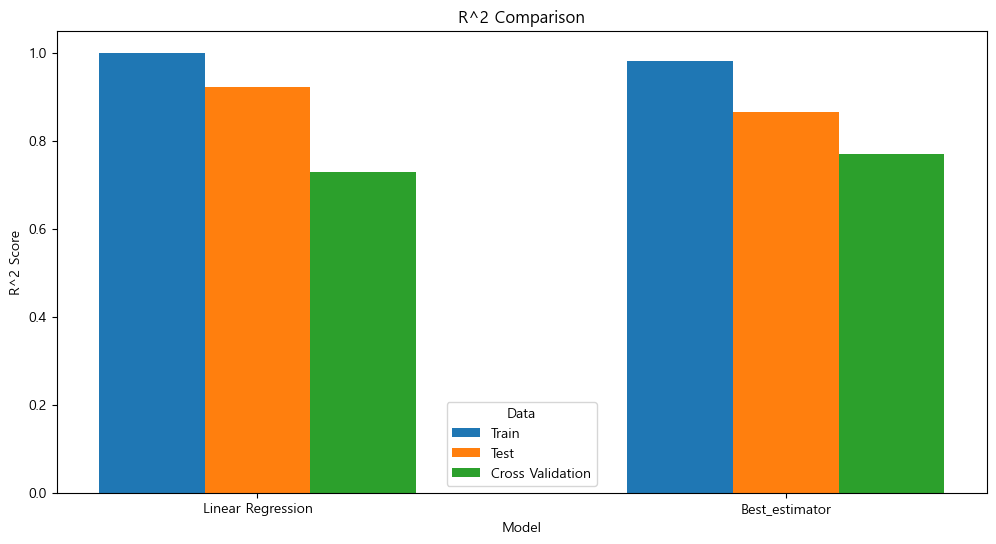

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 제공된 데이터를 사용하여 데이터프레임 생성
data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Linear Regression', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [0.000002, 4516.677970, 205.426726, 7674.885477, 1783.123574, 1708.675202],
    'MAE': [0.000970, 33.911430, 8.244508, 40.114066, 24.047939, 23.446047],
    'R^2': [1.000000, 0.921121, 0.981405, 0.865966, 0.730010, 0.769462]
}

results_df = pd.DataFrame(data)

# 전체 데이터를 보기 좋게 출력합니다.
print(results_df.to_markdown(index=False, numalign='left', stralign='left', floatfmt='.5f'))

# 주어진 metric에 대한 막대 그래프를 그리는 함수입니다.
def plot_results(metric_name, y_axis_label, plot_title):
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    model_indices = range(len(results_df['Model'].unique()))
    for i, data_type in enumerate(results_df['Data'].unique()):
        data_subset = results_df[results_df['Data'] == data_type]
        plt.bar([x + i * bar_width for x in model_indices], data_subset[metric_name], width=bar_width, label=data_type)
    plt.xlabel('Model')
    plt.ylabel(y_axis_label)
    plt.title(plot_title)
    plt.xticks([x + bar_width for x in model_indices], results_df['Model'].unique())
    plt.legend(title='Data')
    plt.show()

# MSE, MAE, R^2 metric에 대한 시각화를 수행합니다.
metrics_to_plot = {'MSE': 'Mean Squared Error', 'MAE': 'Mean Absolute Error', 'R^2': 'R^2 Score'}
for metric_name, y_axis_label in metrics_to_plot.items():
    plot_results(metric_name, y_axis_label, f'{metric_name} Comparison')
